In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Colab/SL_project'

## Visualisation

In [ ]:
def visualize_r(res_lib, res_mod, r_min, r_max, thrs, step=0.1):

    plt.rcParams.update({'font.size': 14}) 

    R = np.arange(r_min, r_max, step)

    fig = plt.figure(figsize=(6,4), dpi=100)

    results_m = []
    for key, value in res_mod.items():
        r, t = key
        if t == thrs:
            results_m.append(value)

    plt.plot(R, res_lib, '--', label='Standard RNN')
    plt.plot(R, results_m, label='Our Model')

    plt.grid(True)
    plt.xlabel("r")
    plt.ylabel("CV Accuracy")

    plt.legend()

    plt.show()
    fig.savefig('plot.png', dpi=300)

In [ ]:
def visualize_t(res_mod, R, thrs_min=0.5, thrs_max=0.9, step=0.05):

    plt.rcParams.update({'font.size': 14}) 

    T = np.arange(thrs_min, thrs_max, step)

    fig = plt.figure(figsize=(6,4), dpi=100)

    results_m = []
    for key, value in res_mod.items():
        r, t = key
        # print(r, R)
        if r == R:
            results_m.append(value)
    
    # print(results_m)
    plt.plot(T, results_m, label='Our Model')

    plt.grid(True)
    plt.xlabel("threshold")
    plt.ylabel("CV Accuracy")

    plt.legend()

    plt.show()
    fig.savefig('plot.png', dpi=300)

## Euclidean distance

In [ ]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1-x2)**2))

## Standard RNN

In [ ]:
def library_rnn(X, y, r_min=0.3, r_max=3.1, step=0.1):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    kf = KFold(n_splits=5, shuffle=True, random_state=42) # 5-fold cross val

    R = np.arange(r_min, r_max, step) # range of hyperparameter r
    res = [] #stores accuracy scores for each r

    for r in R:

      scores = []

      for train_index, val_index in kf.split(X_train):

          X_train_cv, X_val_cv = X_train[train_index], X_train[val_index]
          y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]

          N, M = X_train_cv.shape[0], X_train_cv.shape[1]

          cls = RadiusNeighborsClassifier(r)
          cls.fit(X_train_cv, y_train_cv)

          labels = cls.predict(X_val_cv)
          score = accuracy_score(labels, y_val_cv)
          scores.append(score)

      acc = sum(scores)/len(scores)
      res.append(acc)
      print("For r = {:.2f} cv accuracy is {:.2f}".format(r, acc))

    best_res = max(res)
    best_r = R[np.argmax(np.array(res))]

    ### on the test set

    cls = RadiusNeighborsClassifier(best_r)
    cls.fit(X_train, y_train)
    
    labels = cls.predict(X_test)
    test_score = accuracy_score(labels, y_test)

    print("\nBest r = {:.2f} with best cv accuracy = {:.2f}\nTest accuracy = {}".format(best_r, best_res, test_score))

    return best_r, test_score, res

## Modified R-NN

In [ ]:
def compute_ri(X_train, y_train):

    data = [] # contains lists each corresponding to different class
              # the lists contain indexes of examples belonging to that class
    classes = np.unique(y_train, return_counts=False)   # identifying classes
    num_classes = len(classes) 
    classes.sort()

    for c in classes:
        ind = np.where(y_train == c)  # list of indexes of examples corresponding to class c
        data.append(ind)

    N = X_train.shape[0]

    R = np.zeros(N) # contains the largest radii of hypershperes centered at x_i that includes only x_i's class

    for i in range(N):  # for each training example
        distances = []    # distances to points from other classes
        for c in range(num_classes):   # for all other training examples
            if c == y_train[i]: 
                continue    # next class
            else:
                for ind in data[c]:
                    d = euclidean_distance(X_train[i], X_train[ind])
                    distances.append(d)

        R[i] = min(distances) # finds the r_i for x_i

    for c in classes:
        R_c = R[data[c]] # data[c] - indexes of x_i's of class c # R_c - interclass r_i's
        max_r_c = np.max(R_c) # for normalizing
        R[data[c]] = R_c / max_r_c 

    return R

In [ ]:
def modified_rnn_prediction(x_test, X_train, y_train, R, r=0.4, thrs=0.5): 

  N = X_train.shape[0]

  distances = np.zeros((N, 2)) # stores indexes of the examples in the 1st column, and the distances from x_test to x_i in the 2nd

  i = 0
  for x_i in X_train:
    d = euclidean_distance(x_test, x_i)
    distances[i, 0] = i
    distances[i, 1] = d
    i += 1

  distances = distances[distances[:,1].argsort()] # sort rows by distances

  nn_ind = int(distances[0,0]) # index of the nearest neighbor of x_test

  if R[nn_ind] > thrs:  # meaning r_i is large 
      prediction = y_train[nn_ind]  # perform 1-N
  else:
    nn = []   # stores global indexes of nearest neighbors located within r (standard RNN radius)

    for i in range(N):
        d = euclidean_distance(x_test, X_train[i]) 
        if d <= r:
            nn.append(i)
            
    if len(nn) == 0:
        raise ValueError('No neighbors found. Choose larger r.')
    
    nn_y = y_train[nn]  # labels corresponding to indexes of the nearest neighbors

    classes_nn, counts = np.unique(nn_y, return_counts = True) # identify classes of the nearest neighbors

    centroids = [] # stores tuples of local centroids' classes and their coordinates

    # loop over classes that exist in my neighborhood of radius r
    for c in classes_nn:
        # for each class we get indexes
        local_ind = np.where(nn_y == c)[0]  # local indexes of nearest neighbors which have class c
        local_ind = [int(n) for n in local_ind] # ensuring indexes has to be of type int
        nn = np.array(nn) 
        global_ind = nn[local_ind] #indexes of nn of class c 
        centroids.append((c, np.mean(X_train[global_ind], axis=0)))
    
    # algorithm to find min
    min_class = -1
    min_dist = 1000000
    for centroid in centroids:
        c, cpoint = centroid
        d = euclidean_distance(x_test, cpoint)
        if d < min_dist:
            min_dist = d
            min_class = c

    prediction = min_class

  return prediction

In [ ]:
def modified_rnn(X, y, r_min=0.2, r_max=1, step_r=0.1, thrs_min=0.5, thrs_max=0.9, step_t=0.05):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    R = np.arange(r_min, r_max, step_r)
    THRS = np.arange(thrs_min, thrs_max, step_t)

    HYP = np.array(np.meshgrid(R, THRS)).T.reshape(-1,2)
    print(len(HYP))

    res = []
    res_dict = {}

    for r, thrs in HYP:
        scores = []

        for train_index, val_index in kf.split(X_train):

            X_train_cv, X_val_cv = X_train[train_index], X_train[val_index]
            y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]

            N = X_val_cv.shape[0]
            labels = np.zeros(N)

            R_cv = compute_ri(X_train_cv, y_train_cv)
            
            for i in range(N):
                labels[i] = modified_rnn_prediction(X_val_cv[i], X_train_cv, y_train_cv, R_cv, r=r, thrs=thrs)

            score = accuracy_score(labels, y_val_cv)
            scores.append(score)

        acc = sum(scores)/len(scores)
        res.append(acc)
        res_dict[(r, thrs)] = acc
        print("For r = {:.2f} and thrs = {:.2f}, cv accuracy is {}".format(r, thrs, acc))

    best_res = max(res)
    best_hyp = HYP[np.argmax(np.array(res))]
    best_r, best_thrs = best_hyp

    ### on the test set

    N = X_test.shape[0]
    labels = np.zeros(N)

    R = compute_ri(X_train, y_train)

    for i in range(N):
        labels[i] = modified_rnn_prediction(X_test[i], X_train, y_train, R, r=best_r)

    test_score = accuracy_score(labels, y_test)

    print("\nBest r = {:.2f} and best thrs = {:.2f}, with best cv accuracy = {}\nTest accuracy = {}".format(best_r, best_thrs, best_res, test_score))

    print(res_dict)
    return best_r, best_thrs, test_score, res_dict

## Dataset

### Iris

In [ ]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

scaler = StandardScaler()
X = scaler.fit_transform(X)

r_min = 1.4
r_max = 3.1

t_min = 0.1

In [ ]:
best_r_lib_iris, test_score_lib_iris, res_lib_iris = library_rnn(X, y, r_min, r_max)

For r = 1.40 cv accuracy is 0.88
For r = 1.50 cv accuracy is 0.86
For r = 1.60 cv accuracy is 0.85
For r = 1.70 cv accuracy is 0.86
For r = 1.80 cv accuracy is 0.82
For r = 1.90 cv accuracy is 0.82
For r = 2.00 cv accuracy is 0.83
For r = 2.10 cv accuracy is 0.80
For r = 2.20 cv accuracy is 0.81
For r = 2.30 cv accuracy is 0.82
For r = 2.40 cv accuracy is 0.80
For r = 2.50 cv accuracy is 0.80
For r = 2.60 cv accuracy is 0.80
For r = 2.70 cv accuracy is 0.81
For r = 2.80 cv accuracy is 0.78
For r = 2.90 cv accuracy is 0.79
For r = 3.00 cv accuracy is 0.78

Best r = 1.40 with best cv accuracy = 0.88
Test accuracy = 0.9666666666666667


In [ ]:
best_r_mod_iris, best_thrs_mod_iris, test_score_mod_iris, res_mod_iris = modified_rnn(X, y, r_min, r_max, thrs_min=t_min)

272
For r = 1.40 and thrs = 0.10, cv accuracy is 0.9416666666666667
For r = 1.40 and thrs = 0.15, cv accuracy is 0.9416666666666667
For r = 1.40 and thrs = 0.20, cv accuracy is 0.9416666666666667
For r = 1.40 and thrs = 0.25, cv accuracy is 0.9416666666666667
For r = 1.40 and thrs = 0.30, cv accuracy is 0.9416666666666667
For r = 1.40 and thrs = 0.35, cv accuracy is 0.9416666666666667
For r = 1.40 and thrs = 0.40, cv accuracy is 0.9416666666666667
For r = 1.40 and thrs = 0.45, cv accuracy is 0.95
For r = 1.40 and thrs = 0.50, cv accuracy is 0.95
For r = 1.40 and thrs = 0.55, cv accuracy is 0.95
For r = 1.40 and thrs = 0.60, cv accuracy is 0.95
For r = 1.40 and thrs = 0.65, cv accuracy is 0.95
For r = 1.40 and thrs = 0.70, cv accuracy is 0.95
For r = 1.40 and thrs = 0.75, cv accuracy is 0.95
For r = 1.40 and thrs = 0.80, cv accuracy is 0.95
For r = 1.40 and thrs = 0.85, cv accuracy is 0.95
For r = 1.50 and thrs = 0.10, cv accuracy is 0.9416666666666667
For r = 1.50 and thrs = 0.15, cv a

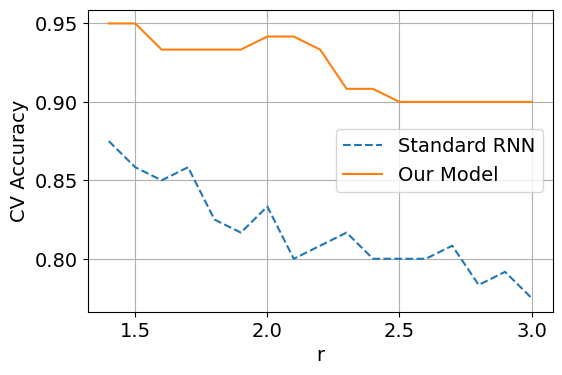

In [ ]:
visualize_r(res_lib_iris, res_mod_iris, r_min, r_max, thrs=best_thrs_mod_iris)

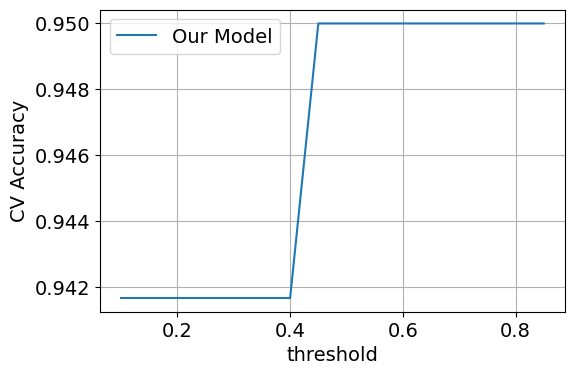

In [ ]:
visualize_t(res_mod_iris, thrs_min=t_min, R=best_r_mod_iris)

### Wine

In [ ]:
wine = datasets.load_wine()
X = wine.data
y = wine.target

scaler = StandardScaler()
X = scaler.fit_transform(X)

r_min = 4.1
r_max = 6

In [ ]:
best_r_lib_w, test_score_lib_w, res_lib_w = library_rnn(X, y, r_min, r_max)

For r = 4.10 cv accuracy is 0.94
For r = 4.20 cv accuracy is 0.96
For r = 4.30 cv accuracy is 0.96
For r = 4.40 cv accuracy is 0.96
For r = 4.50 cv accuracy is 0.95
For r = 4.60 cv accuracy is 0.94
For r = 4.70 cv accuracy is 0.92
For r = 4.80 cv accuracy is 0.92
For r = 4.90 cv accuracy is 0.92
For r = 5.00 cv accuracy is 0.89
For r = 5.10 cv accuracy is 0.87
For r = 5.20 cv accuracy is 0.83
For r = 5.30 cv accuracy is 0.80
For r = 5.40 cv accuracy is 0.80
For r = 5.50 cv accuracy is 0.79
For r = 5.60 cv accuracy is 0.78
For r = 5.70 cv accuracy is 0.74
For r = 5.80 cv accuracy is 0.73
For r = 5.90 cv accuracy is 0.67
For r = 6.00 cv accuracy is 0.63

Best r = 4.20 with best cv accuracy = 0.96
Test accuracy = 0.9722222222222222


In [ ]:
best_r_mod_w, best_thrs_mod_w, test_score_mod_w, res_mod_w = modified_rnn(X, y, r_min, r_max)

140
For r = 4.10 and thrs = 0.60, cv accuracy is 0.9440886699507389
For r = 4.10 and thrs = 0.65, cv accuracy is 0.951231527093596
For r = 4.10 and thrs = 0.70, cv accuracy is 0.9440886699507389
For r = 4.10 and thrs = 0.75, cv accuracy is 0.9440886699507389
For r = 4.10 and thrs = 0.80, cv accuracy is 0.9438423645320198
For r = 4.10 and thrs = 0.85, cv accuracy is 0.9366995073891626
For r = 4.10 and thrs = 0.90, cv accuracy is 0.9366995073891626
For r = 4.20 and thrs = 0.60, cv accuracy is 0.9438423645320198
For r = 4.20 and thrs = 0.65, cv accuracy is 0.9509852216748769
For r = 4.20 and thrs = 0.70, cv accuracy is 0.9438423645320198
For r = 4.20 and thrs = 0.75, cv accuracy is 0.9366995073891626
For r = 4.20 and thrs = 0.80, cv accuracy is 0.9364532019704435
For r = 4.20 and thrs = 0.85, cv accuracy is 0.9293103448275863
For r = 4.20 and thrs = 0.90, cv accuracy is 0.9293103448275863
For r = 4.30 and thrs = 0.60, cv accuracy is 0.9438423645320198
For r = 4.30 and thrs = 0.65, cv accu

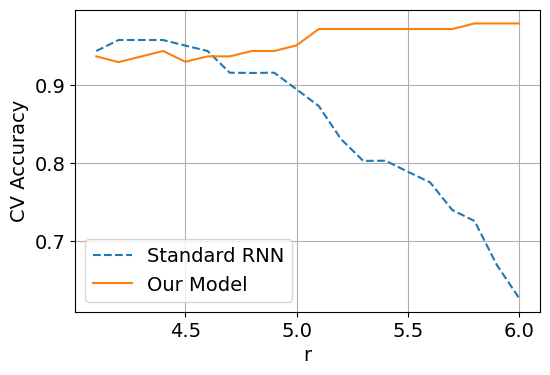

In [ ]:
visualize_r(res_lib_w, res_mod_w, r_min, r_max, thrs=best_thrs_mod_w)

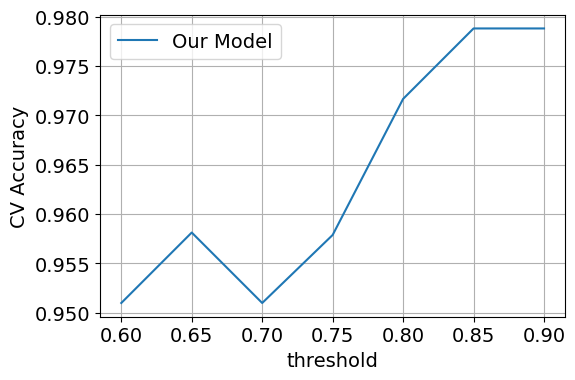

In [ ]:
visualize_t(res_mod_w, R=best_r_mod_w)

### Pima

In [ ]:
pima = pd.read_csv(
    'https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv', 
    delimiter=',', header=None)

In [ ]:
pima = pima.to_numpy()
X = pima[:, :-1]
y = pima[:, -1].astype('int')

scaler = StandardScaler()
X = scaler.fit_transform(X)

r_min = 4.5
r_max = 9.0

t_min = 0.3

In [ ]:
best_r_lib_p, test_score_lib_p, res_lib_p = library_rnn(X, y, r_min, r_max)

For r = 4.50 cv accuracy is 0.66
For r = 4.60 cv accuracy is 0.66
For r = 4.70 cv accuracy is 0.66
For r = 4.80 cv accuracy is 0.67
For r = 4.90 cv accuracy is 0.66
For r = 5.00 cv accuracy is 0.66
For r = 5.10 cv accuracy is 0.66
For r = 5.20 cv accuracy is 0.66
For r = 5.30 cv accuracy is 0.65
For r = 5.40 cv accuracy is 0.65
For r = 5.50 cv accuracy is 0.65
For r = 5.60 cv accuracy is 0.65
For r = 5.70 cv accuracy is 0.65
For r = 5.80 cv accuracy is 0.65
For r = 5.90 cv accuracy is 0.65
For r = 6.00 cv accuracy is 0.65
For r = 6.10 cv accuracy is 0.66
For r = 6.20 cv accuracy is 0.65
For r = 6.30 cv accuracy is 0.66
For r = 6.40 cv accuracy is 0.65
For r = 6.50 cv accuracy is 0.65
For r = 6.60 cv accuracy is 0.65
For r = 6.70 cv accuracy is 0.65
For r = 6.80 cv accuracy is 0.65
For r = 6.90 cv accuracy is 0.65
For r = 7.00 cv accuracy is 0.65
For r = 7.10 cv accuracy is 0.65
For r = 7.20 cv accuracy is 0.65
For r = 7.30 cv accuracy is 0.65
For r = 7.40 cv accuracy is 0.65
For r = 7.

In [ ]:
best_r_mod_p, best_thrs_mod_p, test_score_mod_p, res_mod_p = modified_rnn(X, y, r_min, r_max, thrs_min=t_min)

585
For r = 4.50 and thrs = 0.30, cv accuracy is 0.7313341330134614
For r = 4.50 and thrs = 0.35, cv accuracy is 0.7329734772757565
For r = 4.50 and thrs = 0.40, cv accuracy is 0.7345595095295215
For r = 4.50 and thrs = 0.45, cv accuracy is 0.7296548047447688
For r = 4.50 and thrs = 0.50, cv accuracy is 0.7247767559642809
For r = 4.50 and thrs = 0.55, cv accuracy is 0.7248034119685458
For r = 4.50 and thrs = 0.60, cv accuracy is 0.7215380514460883
For r = 4.50 and thrs = 0.65, cv accuracy is 0.7101426096228176
For r = 4.50 and thrs = 0.70, cv accuracy is 0.7068905771024924
For r = 4.50 and thrs = 0.75, cv accuracy is 0.7068905771024924
For r = 4.50 and thrs = 0.80, cv accuracy is 0.7068905771024924
For r = 4.50 and thrs = 0.85, cv accuracy is 0.7068905771024924
For r = 4.50 and thrs = 0.90, cv accuracy is 0.7068905771024924
For r = 4.60 and thrs = 0.30, cv accuracy is 0.7313341330134614
For r = 4.60 and thrs = 0.35, cv accuracy is 0.7329734772757565
For r = 4.60 and thrs = 0.40, cv acc

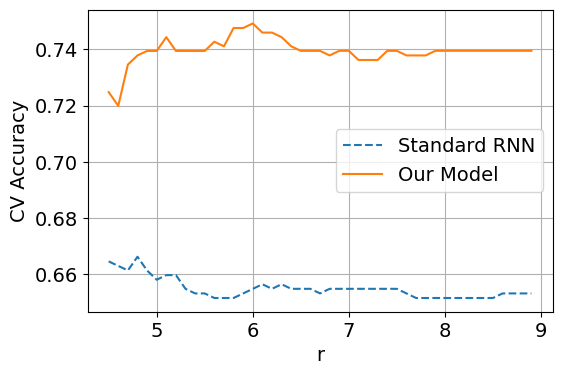

In [ ]:
visualize_r(res_lib_p, res_mod_p, r_min, r_max, thrs=best_thrs_mod_p)

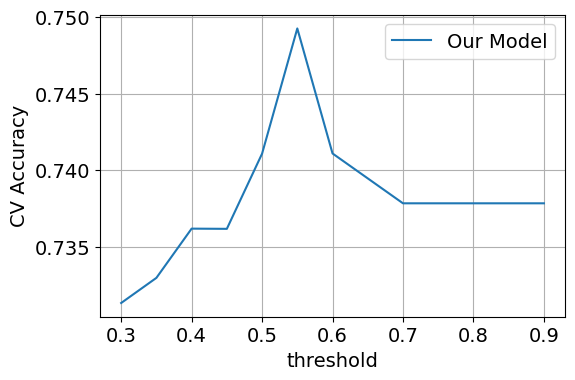

In [ ]:
visualize_t(res_mod_p, thrs_min=t_min, R=best_r_mod_p)

### Ionosphere

In [ ]:
io = pd.read_csv(
   os.path.join(path, 'ionosphere.data'), header = None)

In [ ]:
io[34] = io[34].replace({'g':1, 'b':0})

In [ ]:
io = io.to_numpy()
X = io[:, :-1]
y = io[:, -1].astype('int')

scaler = StandardScaler()
X = scaler.fit_transform(X)

r_min = 10.1
r_max = 13.1

In [ ]:
best_r_lib_io, test_score_lib_io, res_lib_io= library_rnn(X, y, r_min, r_max)

For r = 10.10 cv accuracy is 0.70
For r = 10.20 cv accuracy is 0.69
For r = 10.30 cv accuracy is 0.69
For r = 10.40 cv accuracy is 0.69
For r = 10.50 cv accuracy is 0.68
For r = 10.60 cv accuracy is 0.68
For r = 10.70 cv accuracy is 0.68
For r = 10.80 cv accuracy is 0.67
For r = 10.90 cv accuracy is 0.67
For r = 11.00 cv accuracy is 0.66
For r = 11.10 cv accuracy is 0.66
For r = 11.20 cv accuracy is 0.66
For r = 11.30 cv accuracy is 0.66
For r = 11.40 cv accuracy is 0.66
For r = 11.50 cv accuracy is 0.65
For r = 11.60 cv accuracy is 0.66
For r = 11.70 cv accuracy is 0.65
For r = 11.80 cv accuracy is 0.65
For r = 11.90 cv accuracy is 0.65
For r = 12.00 cv accuracy is 0.65
For r = 12.10 cv accuracy is 0.65
For r = 12.20 cv accuracy is 0.65
For r = 12.30 cv accuracy is 0.65
For r = 12.40 cv accuracy is 0.65
For r = 12.50 cv accuracy is 0.65
For r = 12.60 cv accuracy is 0.65
For r = 12.70 cv accuracy is 0.65
For r = 12.80 cv accuracy is 0.65
For r = 12.90 cv accuracy is 0.65
For r = 13.00 

In [ ]:
best_r_mod_io, best_thrs_mod_io, test_score_mod_io, res_mod_io = modified_rnn(X, y, r_min, r_max) 

210
For r = 10.10 and thrs = 0.60, cv accuracy is 0.8321428571428571
For r = 10.10 and thrs = 0.65, cv accuracy is 0.8428571428571429
For r = 10.10 and thrs = 0.70, cv accuracy is 0.8535714285714284
For r = 10.10 and thrs = 0.75, cv accuracy is 0.8678571428571429
For r = 10.10 and thrs = 0.80, cv accuracy is 0.8678571428571429
For r = 10.10 and thrs = 0.85, cv accuracy is 0.8
For r = 10.10 and thrs = 0.90, cv accuracy is 0.775
For r = 10.20 and thrs = 0.60, cv accuracy is 0.8321428571428571
For r = 10.20 and thrs = 0.65, cv accuracy is 0.8428571428571429
For r = 10.20 and thrs = 0.70, cv accuracy is 0.8535714285714284
For r = 10.20 and thrs = 0.75, cv accuracy is 0.8678571428571429
For r = 10.20 and thrs = 0.80, cv accuracy is 0.8642857142857142
For r = 10.20 and thrs = 0.85, cv accuracy is 0.7964285714285715
For r = 10.20 and thrs = 0.90, cv accuracy is 0.7714285714285715
For r = 10.30 and thrs = 0.60, cv accuracy is 0.8321428571428571
For r = 10.30 and thrs = 0.65, cv accuracy is 0.8

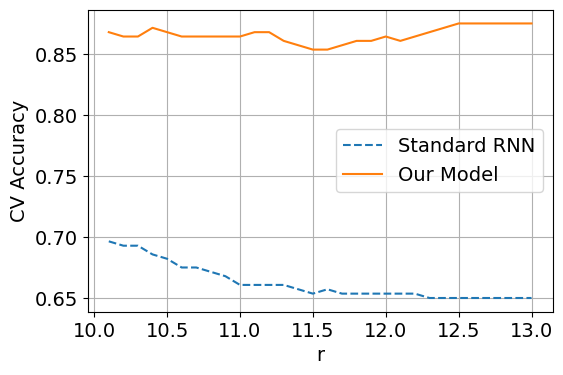

In [ ]:
visualize_r(res_lib_io, res_mod_io, r_min, r_max, thrs=best_thrs_mod_io)

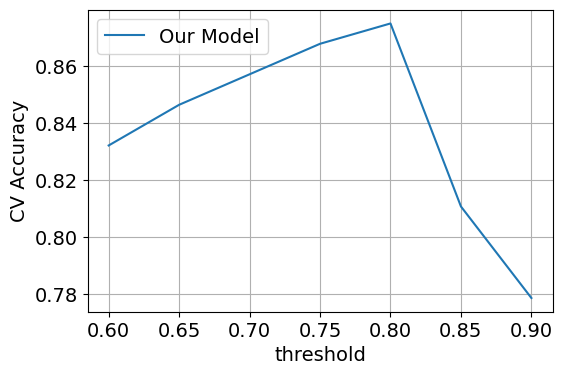

In [ ]:
visualize_t(res_mod_io, R=best_r_mod_io)

### Sonar

In [ ]:
# sonar = pd.read_csv(os.path.join(path, 'sonar.all-data'), header = None)
sonar = pd.read_csv('sonar.all-data', header = None)

In [ ]:
sonar[60] = sonar[60].replace({'R':1, 'M':0})

In [ ]:
sonar = sonar.to_numpy()
X = sonar[:, :-1]
y = sonar[:, -1].astype('int')

scaler = StandardScaler()
X = scaler.fit_transform(X)

r_min = 12.8
r_max = 15

t_min = 0.1

In [ ]:
best_r_lib_s, test_score_lib_s, res_lib_s = library_rnn(X, y, r_min, r_max)

For r = 12.80 cv accuracy is 0.54
For r = 12.90 cv accuracy is 0.56
For r = 13.00 cv accuracy is 0.57
For r = 13.10 cv accuracy is 0.58
For r = 13.20 cv accuracy is 0.55
For r = 13.30 cv accuracy is 0.55
For r = 13.40 cv accuracy is 0.55
For r = 13.50 cv accuracy is 0.57
For r = 13.60 cv accuracy is 0.57
For r = 13.70 cv accuracy is 0.55
For r = 13.80 cv accuracy is 0.55
For r = 13.90 cv accuracy is 0.57
For r = 14.00 cv accuracy is 0.54
For r = 14.10 cv accuracy is 0.54
For r = 14.20 cv accuracy is 0.53
For r = 14.30 cv accuracy is 0.54
For r = 14.40 cv accuracy is 0.52
For r = 14.50 cv accuracy is 0.48
For r = 14.60 cv accuracy is 0.47
For r = 14.70 cv accuracy is 0.48
For r = 14.80 cv accuracy is 0.49
For r = 14.90 cv accuracy is 0.49

Best r = 13.10 with best cv accuracy = 0.58
Test accuracy = 0.6904761904761905


In [ ]:
best_r_mod_s, best_thrs_mod_s, test_score_mod_s, res_mod_s = modified_rnn(X, y, r_min, r_max, thrs_min=t_min)

352
For r = 12.80 and thrs = 0.10, cv accuracy is 0.8429590017825312
For r = 12.80 and thrs = 0.15, cv accuracy is 0.8429590017825312
For r = 12.80 and thrs = 0.20, cv accuracy is 0.8429590017825312
For r = 12.80 and thrs = 0.25, cv accuracy is 0.8429590017825312
For r = 12.80 and thrs = 0.30, cv accuracy is 0.8429590017825312
For r = 12.80 and thrs = 0.35, cv accuracy is 0.8429590017825312
For r = 12.80 and thrs = 0.40, cv accuracy is 0.8429590017825312
For r = 12.80 and thrs = 0.45, cv accuracy is 0.8429590017825312
For r = 12.80 and thrs = 0.50, cv accuracy is 0.8247771836007131
For r = 12.80 and thrs = 0.55, cv accuracy is 0.8128342245989305
For r = 12.80 and thrs = 0.60, cv accuracy is 0.8067736185383245
For r = 12.80 and thrs = 0.65, cv accuracy is 0.7704099821746879
For r = 12.80 and thrs = 0.70, cv accuracy is 0.7645276292335116
For r = 12.80 and thrs = 0.75, cv accuracy is 0.7467023172905526
For r = 12.80 and thrs = 0.80, cv accuracy is 0.7345811051693405
For r = 12.80 and thr

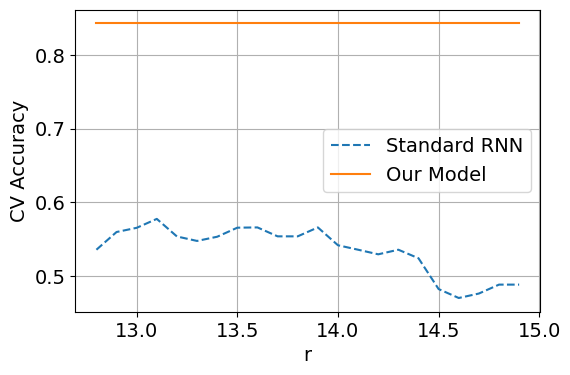

In [ ]:
visualize_r(res_lib_s, res_mod_s, r_min, r_max, thrs=best_thrs_mod_s)

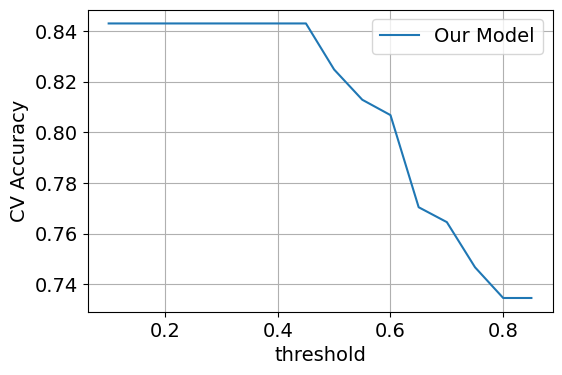

In [ ]:
visualize_t(res_mod_s, thrs_min=t_min, R=best_r_mod_s)

### Liver

In [ ]:
liver = pd.read_csv(
    'https://datahub.io/machine-learning/liver-disorders/r/1.csv', 
    delimiter=',')

In [ ]:
liver['selector'] = liver['selector'].replace({2:1, 1:0})

In [ ]:
liver = liver.to_numpy()
X = liver[:, :-1]
y = liver[:, -1].astype('int')

scaler = StandardScaler()
X = scaler.fit_transform(X)

r_min = 3.1
r_max = 12.0

t_min = 0.3

In [ ]:
best_r_lib_l, test_score_lib_l, res_lib_l = library_rnn(X, y, r_min, r_max)

For r = 3.10 cv accuracy is 0.54
For r = 3.20 cv accuracy is 0.55
For r = 3.30 cv accuracy is 0.55
For r = 3.40 cv accuracy is 0.56
For r = 3.50 cv accuracy is 0.57
For r = 3.60 cv accuracy is 0.57
For r = 3.70 cv accuracy is 0.56
For r = 3.80 cv accuracy is 0.56
For r = 3.90 cv accuracy is 0.56
For r = 4.00 cv accuracy is 0.56
For r = 4.10 cv accuracy is 0.56
For r = 4.20 cv accuracy is 0.56
For r = 4.30 cv accuracy is 0.56
For r = 4.40 cv accuracy is 0.57
For r = 4.50 cv accuracy is 0.57
For r = 4.60 cv accuracy is 0.58
For r = 4.70 cv accuracy is 0.57
For r = 4.80 cv accuracy is 0.58
For r = 4.90 cv accuracy is 0.58
For r = 5.00 cv accuracy is 0.58
For r = 5.10 cv accuracy is 0.58
For r = 5.20 cv accuracy is 0.58
For r = 5.30 cv accuracy is 0.58
For r = 5.40 cv accuracy is 0.58
For r = 5.50 cv accuracy is 0.58
For r = 5.60 cv accuracy is 0.57
For r = 5.70 cv accuracy is 0.58
For r = 5.80 cv accuracy is 0.58
For r = 5.90 cv accuracy is 0.58
For r = 6.00 cv accuracy is 0.57
For r = 6.

In [ ]:
best_r_mod_l, best_thrs_mod_l, test_score_mod_l, res_mod_l = modified_rnn(X, y, r_min, r_max, thrs_min=t_min)

1157
For r = 3.10 and thrs = 0.30, cv accuracy is 0.5616233766233766
For r = 3.10 and thrs = 0.35, cv accuracy is 0.5833116883116883
For r = 3.10 and thrs = 0.40, cv accuracy is 0.5944155844155843
For r = 3.10 and thrs = 0.45, cv accuracy is 0.5944805194805195
For r = 3.10 and thrs = 0.50, cv accuracy is 0.6161688311688311
For r = 3.10 and thrs = 0.55, cv accuracy is 0.6161688311688311
For r = 3.10 and thrs = 0.60, cv accuracy is 0.6088961038961038
For r = 3.10 and thrs = 0.65, cv accuracy is 0.6088961038961038
For r = 3.10 and thrs = 0.70, cv accuracy is 0.6088961038961038
For r = 3.10 and thrs = 0.75, cv accuracy is 0.6088961038961038
For r = 3.10 and thrs = 0.80, cv accuracy is 0.6088961038961038
For r = 3.10 and thrs = 0.85, cv accuracy is 0.6088961038961038
For r = 3.10 and thrs = 0.90, cv accuracy is 0.6088961038961038
For r = 3.20 and thrs = 0.30, cv accuracy is 0.5797402597402598
For r = 3.20 and thrs = 0.35, cv accuracy is 0.5977922077922078
For r = 3.20 and thrs = 0.40, cv ac

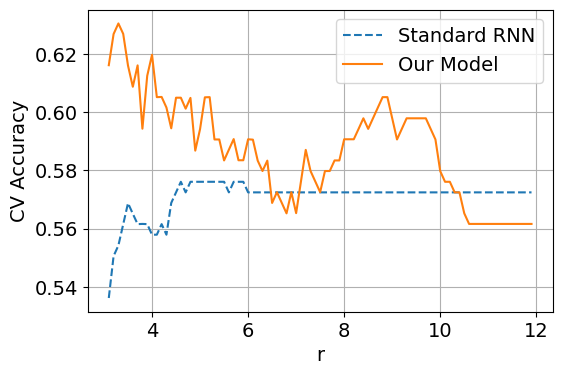

In [ ]:
visualize_r(res_lib_l, res_mod_l, r_min, r_max, thrs=best_thrs_mod_l)

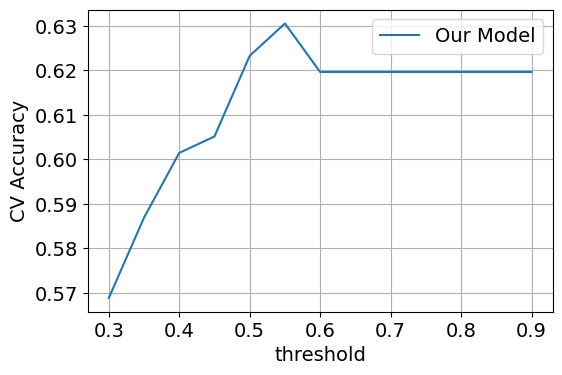

In [ ]:
visualize_t(res_mod_l, thrs_min=t_min, R=best_r_mod_l)